In [ ]:
%%capture
!pip install pytorch-forecasting
# !pip install pytorch-lightning==1.1.8
!pip install pytorch-lightning
!pip install neptune-client

In [ ]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from tqdm import tqdm
from pytorch_lightning.loggers.neptune import NeptuneLogger
import types
import matplotlib.pyplot as plt
from matplotlib import cm
import random 

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
NEPTUNE_API_KEY = ""

DATA_PATH = 'data.csv' #path to preprocessed csv data
TARGET = 'target'
FEATURES = ['dose', 'time']
GROUP_ID = 'series'

In [ ]:
dataset = pd.read_csv(DATA_PATH)

In [ ]:
dataset.shape #21 * 200 000

(4200000, 7)

In [ ]:
neptune_logger = NeptuneLogger(
    api_key=NEPTUNE_API_KEY,
    project_name="TensorCell/graphneuralnetworks",
    close_after_fit=False,

)

NeptuneLogger will work in online mode


In [ ]:
n = dataset[GROUP_ID].astype(int).max()

dataset[TARGET] = dataset[TARGET].astype(float)

dataset['time_idx'] = dataset['time_idx'].astype(int)

training = TimeSeriesDataSet(
    dataset[dataset[GROUP_ID].apply(lambda x: int(x) < int(n * 0.7))],
    time_idx="time_idx",
    target=TARGET,
    group_ids=[GROUP_ID],
    min_encoder_length=20,  
    max_encoder_length=20,
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[TARGET] + FEATURES,
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    allow_missings=True,
    categorical_encoders={GROUP_ID: NaNLabelEncoder().fit(dataset.series)},
)

In [ ]:
bs = 1024

In [ ]:
validation_dataset = dataset[dataset[GROUP_ID].apply(lambda x: int(x) > int(n * 0.7) and int(x) < int(n * 0.9))]
validation = TimeSeriesDataSet.from_dataset(training, validation_dataset,
                                            min_prediction_idx=0,
                                            stop_randomization=True)

test_dataset = dataset[dataset[GROUP_ID].apply(lambda x: int(x) > int(n * 0.9))]
test = TimeSeriesDataSet.from_dataset(training, test_dataset,
                                            min_prediction_idx=0,
                                            stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=bs, num_workers=6)
val_dataloader = validation.to_dataloader(train=False, batch_size=bs, num_workers=6)
test_dataloader = test.to_dataloader(train=False, batch_size=bs, num_workers=6)

print(f'len training {len(training)}')
print(f'len validation {len(validation)}')
print(f'len test {len(test)}')

len training 139999
len validation 39999
len test 20000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
val_dataloader

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=8, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

In [ ]:
from pytorch_forecasting.utils import padded_stack

In [ ]:
def _log_interpretation(self, outputs):
    pass

In [ ]:
trainer = pl.Trainer(
    max_epochs=150,
    gpus=1,
    gradient_clip_val=0.7,
    callbacks=[lr_logger, early_stop_callback],
    logger=neptune_logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.05,
    hidden_size=48,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=32,
    output_size=1,
    loss=RMSE(),
    log_interval=1000,
    reduce_on_plateau_patience=5,
)

def _log_prediction(self, x, out, batch_idx):
    pass

TemporalFusionTransformer.log_prediction = types.MethodType(_log_prediction, TemporalFusionTransformer)
TemporalFusionTransformer.log_interpretation = types.MethodType(_log_interpretation, TemporalFusionTransformer)


trainer.fit(
    tft, train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://ui.neptune.ai/TensorCell/graphneuralnetworks/e/GRAP-565



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 384   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 29.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 9.5 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 9.5 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 9.5 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Unexpected error in ping thread.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 391, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.7/dist-packages/six.py", line 703, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 391, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.7/dist-packages/six.py", line 703, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/usr/local/lib/python3.7/dist-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **

<h3> Evaluation </h3>

In [ ]:
#@title Images examples { run: "auto", vertical-output: true }
#@markdown (Double click here to show/hide code.)

best_model_path = 'Untitled/GRAP-564/checkpoints/epoch=135-step=18495.ckpt'
print(f'best model path is {best_model_path}')

best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


actuals = torch.cat([y[0] for (x, y) in iter(test_dataloader)])
predictions = best_tft.predict(test_dataloader)

print(f'test mape is {((actuals - predictions).abs() / actuals).mean()}')

print(f' max mape {max(((actuals - predictions).abs() / actuals))}')

res = (actuals - predictions).abs() / actuals
print(f' max 99 mape {np.quantile(res, .99)}')


res = [(a.item(), p.item()) for a , p in zip(actuals, predictions)]
res.sort() 
res = np.array_split(np.array(res),10)

best model path is Untitled/GRAP-564/checkpoints/epoch=135-step=18495.ckpt
test mape is 0.01679357700049877
 max mape tensor([0.8071])
 max 99 mape 0.06844537608325481


 (0, 10) percentile mape 0.02304744784235477
 (10, 20) percentile mape 0.016464868694677
 (20, 30) percentile mape 0.016251681554273218
 (30, 40) percentile mape 0.016228308970220925
 (40, 50) percentile mape 0.015816622358877045
 (50, 60) percentile mape 0.01542757478150335
 (60, 70) percentile mape 0.01558122947706898
 (70, 80) percentile mape 0.015995093142054065
 (80, 90) percentile mape 0.016426876309846832
 (90, 100) percentile mape 0.016696075742216182


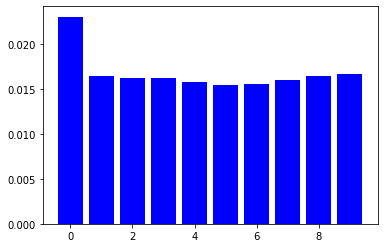

In [ ]:
#@title Images examples { run: "auto", vertical-output: true }
#@markdown (Double click here to show/hide code.)
fig, ax = plt.subplots()
for i, chunk in enumerate(res):
  mape = np.mean([abs(x[0] - x[1]) / x[0] for x in chunk])
  print(f' ({i * 10}, {(i + 1) * 10}) percentile mape {mape}')
  ax.bar(i, mape, 0.8, color='blue')

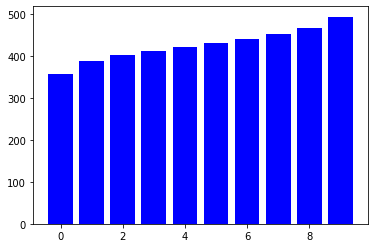

In [ ]:

#@title Images examples { run: "auto", vertical-output: true }
#@markdown (Double click here to show/hide code.)
a = actuals
a = [x.item() for x in a]
a.sort()
res1 = np.array_split(np.array(a),10)
fig, ax = plt.subplots()
for i, chunk in enumerate(res1):
  avg = np.mean(chunk)
  ax.bar(i, avg, 0.8, label='Men', color='blue')

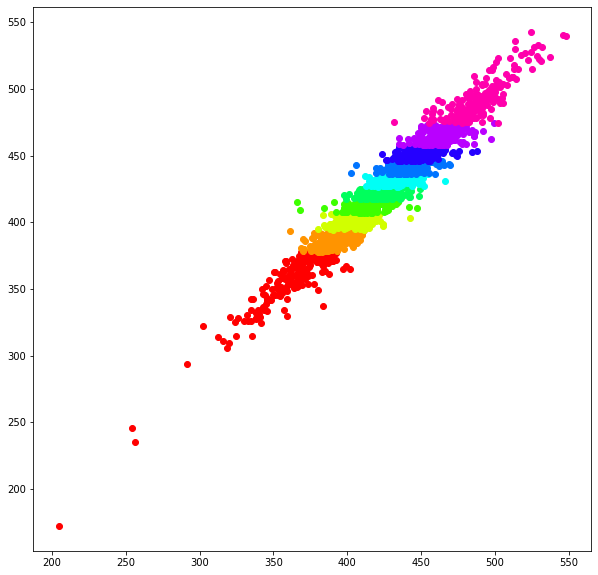

In [ ]:
#@title Images examples { run: "auto", vertical-output: true }
#@markdown (Double click here to show/hide code.)

fig, ax = plt.subplots(figsize=(10,10))

colors = cm.hsv(np.array(range(10)) / 10)
for c, chunk in zip(colors, res):
    chunk = random.sample(list(chunk), 200)
    x = [k[0] for k in chunk]
    y = [k[1] for k in chunk]
    ax.scatter(y, x, color=c)


{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>,
 'encoder_variables': <Figure size 504x234 with 1 Axes>,
 'static_variables': <Figure size 504x162 with 1 Axes>}

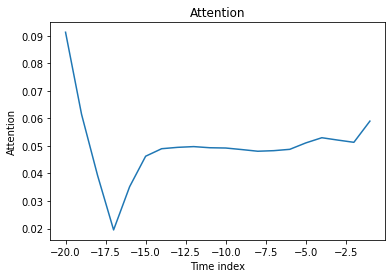

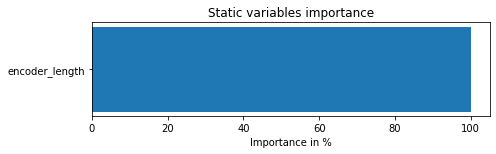

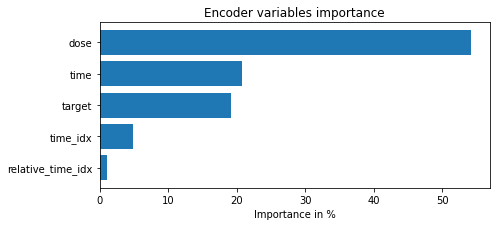

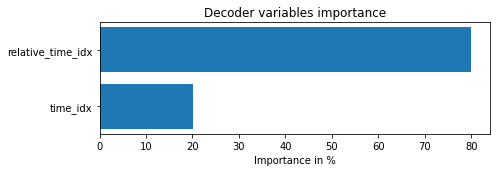

In [ ]:
#@title Images examples { run: "auto", vertical-output: true }
#@markdown (Double click here to show/hide code.)

raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)